In [1]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

fatal: destination path 'Neutron_Reflect' already exists and is not an empty directory.


In [2]:
cd Neutron_Reflect/

/global/u1/q/qubri000/Neutron_Reflect


In [3]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install ray==2.6.3

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install -U tensorboardx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install fsspec

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
# pip install tensorboard==2.12.0

In [10]:
# pip install -U protobuf==3.19.6

In [11]:
pip install gdown

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install -U ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import numpy as np
import data_preparation as dpre
import io
import os
# import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import seaborn as sea

from ray import air, tune
from ray.air import session
from ray.tune.schedulers import ASHAScheduler
from ray.air.checkpoint import Checkpoint


In [16]:
#Loading in NR and SLD curves


!gdown "https://drive.google.com/uc?id=1f_SgtZI4KbVZDmk2kzkkmNsMUhRwoGMQ"
!gdown "https://drive.google.com/uc?id=1eHUkQqYvjkeHP1clWceLthkvJaA5ntOk"
curves_nr = np.load('NR-SLD_CurvesSAMEPoly2DExperiment18000.npy')
curves_SLD = np.load('SLD_CurvesSAMEPoly2DExperiment18000.npy')
curves_nr.shape, curves_SLD.shape


Downloading...
From: https://drive.google.com/uc?id=1f_SgtZI4KbVZDmk2kzkkmNsMUhRwoGMQ
To: /global/u1/q/qubri000/Neutron_Reflect/SLD_CurvesSAMEPoly2DExperiment18000.npy
100%|██████████████████████████████████████| 88.7M/88.7M [00:01<00:00, 49.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eHUkQqYvjkeHP1clWceLthkvJaA5ntOk
To: /global/u1/q/qubri000/Neutron_Reflect/NR-SLD_CurvesSAMEPoly2DExperiment18000.npy
100%|██████████████████████████████████████| 88.7M/88.7M [00:01<00:00, 44.5MB/s]


((18000, 2, 308), (18000, 2, 308))

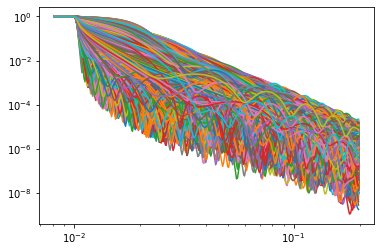

In [18]:
#plot NR curves

for x in range(curves_nr.shape[0]):
  plt.plot(curves_nr[x][0],curves_nr[x][1])
plt.xscale('log')
plt.yscale('log')

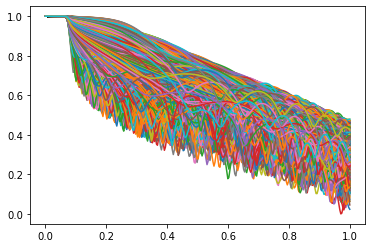

In [19]:
#normalize NR curves

curves_nr = np.log10(curves_nr)

x_points = []
y_points = []
for curve in curves_nr:
    x_points.append(curve[0])
    y_points.append(curve[1])
min_valX = float('inf')
min_valY = float('inf')
max_valX = -float('inf')
max_valY = -float('inf')
for i in range(len(y_points)):
    min_valX = min(min(x_points[i]), min_valX)
    min_valY = min(min(y_points[i]), min_valY)
    max_valX = max(max(x_points[i]), max_valX)
    max_valY = max(max(y_points[i]), max_valY)
for i in range(len(y_points)):
    for j in range(len(y_points[0])):
        x_points[i][j] -= min_valX
        y_points[i][j] -= min_valY
        x_points[i][j] /= (max_valX - min_valX)
        y_points[i][j] /= (max_valY - min_valY)
curves_nr2 = []
for i in range(len(y_points)):
    curves_nr2.append([x_points[i],y_points[i]])
curves_nr2 = np.stack(curves_nr2)
curves_nr2.shape
for x in range(curves_nr.shape[0]):
  plt.plot(curves_nr[x][0],curves_nr[x][1])

[[0.00000000e+00 5.42671010e-01 1.08534202e+00 1.62801303e+00
  2.17068404e+00 2.71335505e+00 3.25602606e+00 3.79869707e+00
  4.34136808e+00 4.88403909e+00 5.42671010e+00 5.96938111e+00
  6.51205212e+00 7.05472313e+00 7.59739414e+00 8.14006515e+00
  8.68273616e+00 9.22540717e+00 9.76807818e+00 1.03107492e+01
  1.08534202e+01 1.13960912e+01 1.19387622e+01 1.24814332e+01
  1.30241042e+01 1.35667752e+01 1.41094463e+01 1.46521173e+01
  1.51947883e+01 1.57374593e+01 1.62801303e+01 1.68228013e+01
  1.73654723e+01 1.79081433e+01 1.84508143e+01 1.89934853e+01
  1.95361564e+01 2.00788274e+01 2.06214984e+01 2.11641694e+01
  2.17068404e+01 2.22495114e+01 2.27921824e+01 2.33348534e+01
  2.38775244e+01 2.44201954e+01 2.49628664e+01 2.55055375e+01
  2.60482085e+01 2.65908795e+01 2.71335505e+01 2.76762215e+01
  2.82188925e+01 2.87615635e+01 2.93042345e+01 2.98469055e+01
  3.03895765e+01 3.09322476e+01 3.14749186e+01 3.20175896e+01
  3.25602606e+01 3.31029316e+01 3.36456026e+01 3.41882736e+01
  3.4730

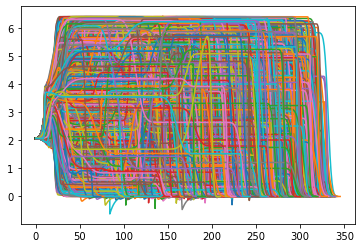

In [20]:
#plot SLD curves

for x in range(curves_nr.shape[0]):
  plt.plot(curves_SLD[x][0],curves_SLD[x][1])
# plt.xscale('log')
# plt.yscale('log')
print(curves_SLD[0])

[[0.         0.00157205 0.0031441  0.00471614 0.00628819 0.00786024
  0.00943229 0.01100434 0.01257638 0.01414843 0.01572048 0.01729253
  0.01886458 0.02043663 0.02200867 0.02358072 0.02515277 0.02672482
  0.02829687 0.02986891 0.03144096 0.03301301 0.03458506 0.03615711
  0.03772915 0.0393012  0.04087325 0.0424453  0.04401735 0.0455894
  0.04716144 0.04873349 0.05030554 0.05187759 0.05344964 0.05502168
  0.05659373 0.05816578 0.05973783 0.06130988 0.06288192 0.06445397
  0.06602602 0.06759807 0.06917012 0.07074217 0.07231421 0.07388626
  0.07545831 0.07703036 0.07860241 0.08017445 0.0817465  0.08331855
  0.0848906  0.08646265 0.08803469 0.08960674 0.09117879 0.09275084
  0.09432289 0.09589494 0.09746698 0.09903903 0.10061108 0.10218313
  0.10375518 0.10532722 0.10689927 0.10847132 0.11004337 0.11161542
  0.11318746 0.11475951 0.11633156 0.11790361 0.11947566 0.1210477
  0.12261975 0.1241918  0.12576385 0.1273359  0.12890795 0.13047999
  0.13205204 0.13362409 0.13519614 0.13676819 0.13

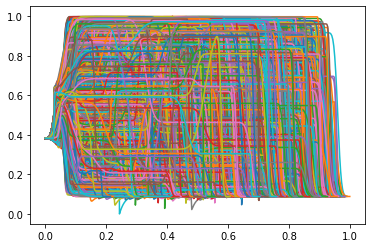

In [21]:
#normalize SLD curves
x_points = []
y_points = []
for curve in curves_SLD:
    x_points.append(curve[0])
    y_points.append(curve[1])
min_valX = float('inf')
min_valY = float('inf')
max_valX = -float('inf')
max_valY = -float('inf')
for i in range(len(y_points)):
    min_valX = min(min(x_points[i]), min_valX)
    min_valY = min(min(y_points[i]), min_valY)
    max_valX = max(max(x_points[i]), max_valX)
    max_valY = max(max(y_points[i]), max_valY)
for i in range(len(y_points)):
    for j in range(len(y_points[0])):
        x_points[i][j] -= min_valX
        y_points[i][j] -= min_valY
        x_points[i][j] /= (max_valX - min_valX)
        y_points[i][j] /= (max_valY - min_valY)
curves_SLD2 = []
for i in range(12000):
    curves_SLD2.append([x_points[i],y_points[i]])
curves_SLD2 = np.stack(curves_SLD2)
for x in range(curves_nr.shape[0]):
  plt.plot(curves_SLD[x][0],curves_SLD[x][1])
# plt.xscale('log')
# plt.yscale('log')
print(curves_SLD[0])

In [22]:
#Make CNN class

class CNN(nn.Module):
    def __init__(self, num_layers):
        super(CNN, self).__init__()
        self.layers = nn.ModuleList()
        addition = 255/num_layers
        curr = 1
        for hdim in range(num_layers-1):
            self.layers.append(nn.Conv1d(int(curr+0.5), int(curr+addition+0.5),51,padding=25))
            self.layers.append(nn.BatchNorm1d(int(curr+addition+0.5)))
            self.layers.append(nn.ReLU(True))
            curr += addition
        self.layers.append(nn.Conv1d(int(curr+0.5), 256, 51, padding=25))
        self.linear1 = nn.Linear(256*308,2*308)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        x = x.reshape(-1, 2, 308)
        return torch.sigmoid(x)

In [23]:
### Define the loss function
loss_fn = torch.nn.MSELoss()
#learning rate
lr= 0.00001

### Set the random seed for reproducible results
torch.manual_seed(0)

#make CNN
Model = CNN(num_layers=5)
params_to_optimize = Model.parameters()

optimizer = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cuda


In [24]:
Model.to(device)

CNN(
  (layers): ModuleList(
    (0): Conv1d(1, 52, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(52, 103, kernel_size=(51,), stride=(1,), padding=(25,))
    (4): BatchNorm1d(103, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(103, 154, kernel_size=(51,), stride=(1,), padding=(25,))
    (7): BatchNorm1d(154, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv1d(154, 205, kernel_size=(51,), stride=(1,), padding=(25,))
    (10): BatchNorm1d(205, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv1d(205, 256, kernel_size=(51,), stride=(1,), padding=(25,))
  )
  (linear1): Linear(in_features=78848, out_features=616, bias=True)
)

In [25]:
## Training function
def fit(Model, dataloader, loss_fn, optim):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    Model.train().to(device)
    train_loss = []
    for data,label in dataloader:
        img = data
        img = img.to(device)
        label = label.to(device)
        decoded_img = Model(img)
        # print(decoded_img.shape)
        # decoded_img = decoded_img.reshape(-1,2, 308)
        loss = loss_fn(decoded_img, label)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss.append(loss.cpu().detach().numpy())
        # print(label, "hello")
    return np.mean(train_loss)

In [26]:
### Valid function
def val(Model, dataloader, loss_fn):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    Model.eval().to(device)
    with torch.no_grad(): 
        list_decoded_img = []
        list_img = []
        for  data, label in dataloader:
            img = data
            # img = img.view(img.size(0), -1).to(device) 
            # img = img[:,np.newaxis,:].to(device) 
            img = img.to(device) 
            label = label.to(device)
            decoded_img = Model(img)
            # decoded_img = decoded_img.reshape(-1,2, 308)
            list_decoded_img.append(decoded_img.cpu())
            list_img.append(label.cpu())
        list_decoded_img = torch.cat(list_decoded_img)
        list_img = torch.cat(list_img)
        # print(list_img, list_decoded_img, "vaLLLLL FUNCTION")
#         for i in range(len(list_img)):
            
        val_loss = loss_fn(list_decoded_img, list_img)
    return val_loss.data

In [27]:
#data split function

def load_data(batch_size, size_split):
    R = curves_nr[:,1]
    R_m = R[:,np.newaxis,:]
    # Q = curves_SLD[:,1]
    # Q_m = Q[:, np.newaxis,:]
    xtrain, ytrain, xval, yval, xtest, ytest = \
    dpre.split_input_arrays(R_m,curves_SLD2, size_split=size_split)
    #Prepare data files, continuation
    train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
    dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=batch_size)

    return train_loader, valid_loader, test_loader

In [28]:
train_loader, valid_loader, test_loader = load_data(32, 0.9)


xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(10800, 1, 308) (10800, 2, 308) (600, 1, 308) (600, 2, 308) (600, 1, 308) (600, 2, 308)


In [41]:
def train_cifar(config):
    net = CNN(num_layers=config["num_layers"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    # To restore a checkpoint, use `session.get_checkpoint()`.
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           model_state, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = fit(net,  train_loader, criterion, optimizer)
        # Validation loss
        val_loss = val(net, valid_loader, criterion)

        # Here we save a checkpoint. It is automatically registered with
        # Ray Tune and can be accessed through `session.get_checkpoint()`
        # API in future iterations.
        os.makedirs("my_model", exist_ok=True)
        torch.save(
            (net.state_dict(), optimizer.state_dict()), "my_model/checkpoint.pt")
        checkpoint = Checkpoint.from_directory("my_model")
        session.report({"loss": (val_loss.item()), "training loss": running_loss}, checkpoint=checkpoint)
    print("Finished Training")

In [42]:
def test_best_model(best_result):
    best_trained_model = CNN(num_layers=best_result.config["num_layers"])
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")
    
    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    testLoss = val(best_trained_model, test_loader, loss_fn)


    print("Best trial test set accuracy: {}".format(testLoss.item()))

In [47]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=1):
    config = {
    "lr": tune.loguniform(1e-5, 1e-3), "weight_decay": tune.loguniform(1e-5, 1e-3), "num_layers":tune.choice([14, 15,16,17,18])
    }
    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_cifar),
            resources={"cpu": 30, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    best_result = results.get_best_result()

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final training loss: {}".format(
        best_result.metrics["training loss"]))
    test_best_model(best_result)

main(num_samples=5, max_num_epochs=700)

2023-08-20 19:11:33,094	WARNING worker.py:2037 -- Warning: The actor ImplicitFunc is very large (80 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(train_cifar pid=1705120) Finished Training
(train_cifar pid=1705118) Finished Training


2023-08-20 19:14:10,103	INFO tune.py:1148 -- Total run time: 157.78 seconds (157.66 seconds for the tuning loop).


(train_cifar pid=1705115) Finished Training
Best trial config: {'lr': 3.167597940227744e-05, 'weight_decay': 0.00014674610084382052, 'num_layers': 15}
Best trial final validation loss: 0.003116089152172208
Best trial final training loss: 0.0032592567149549723
Best trial test set accuracy: 0.002538347849622369


In [ ]:
curves_SLD[0][0][-1]